# `pbdl.loader`

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%4m
Success: Loaded incompressible-wake-flow-tiny with 1 simulations (1 selected) and 1290 samples each.


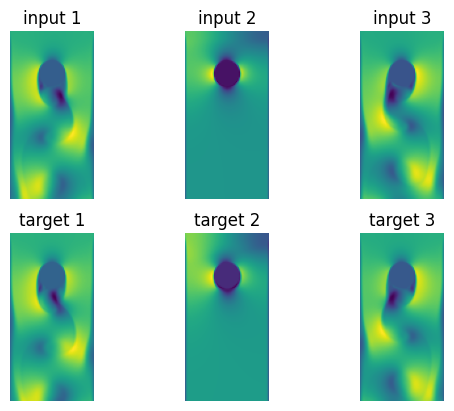

In [1]:
from pbdl.loader import Dataloader
import matplotlib.pyplot as plt

loader = Dataloader(
    "incompressible-wake-flow-tiny",
    time_steps=10,  # interval between input and target frame
    sel_sims=[0],  # select first simulation
    batch_size=3,
    shuffle=True,
)

inputs, targets = next(iter(loader))

for i in range(len(inputs)):
    plt.subplot(2, len(inputs), i + 1)
    plt.imshow(inputs[i][0])  # display field at index 0
    plt.axis("off")
    plt.title("input {}".format(i + 1))

for i in range(len(targets)):
    plt.subplot(2, len(targets), len(targets) + i + 1)
    plt.imshow(targets[i][0])  # display field at index 0
    plt.axis("off")
    plt.title("target {}".format(i + 1))

plt.show()

# `pbdl.torch.loader`

In [3]:
import torch
import numpy as np
from pbdl.torch.loader import Dataloader
import examples.tcf.net_small as net_small

loader = Dataloader(
    "transonic-cylinder-flow-tiny",
    time_steps=10,
    sel_sims=[0, 1],
    step_size=3,
    # normalize="mean-std",
    batch_size=3,
    shuffle=True,
)

net = net_small.NetworkSmall()
criterionL2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.0)

for epoch in range(5):
    for i, (input, target) in enumerate(loader):

        net.zero_grad()
        output = net(input)

        loss = criterionL2(output, target)
        loss.backward()
        optimizer.step()

    print(f"epoch { epoch }, loss { loss.item() }")

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%4m
Success: Loaded transonic-cylinder-flow-tiny with 2 simulations (2 selected) and 330 samples each.
epoch 0, loss 0.007112540304660797
epoch 1, loss 0.002435241360217333
epoch 2, loss 0.0019953185692429543
epoch 3, loss 0.0018918440910056233
epoch 4, loss 0.0022761626169085503


# `pbdl.torch.phi.loader`

In [2]:
import torch
from pbdl.torch.phi.loader import Dataloader
from examples.ks.ks_networks import ConvResNet1D
from examples.ks.ks_solver import DifferentiableKS

# solver parameters
DOMAIN_SIZE_BASE = 8
PREDHORZ = 5

device = "cuda:0" if torch.cuda.is_available() else "cpu"

diff_ks = DifferentiableKS(resolution=48, dt=0.5)

loader = Dataloader(
    "ks-dataset",
    time_steps=PREDHORZ,
    step_size=20,
    intermediate_time_steps=True,
    batch_size=16,
    batch_by_const=[0],
    ret_batch_const=True,
)

net = ConvResNet1D(16, 3, device=device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
loss = torch.nn.MSELoss()

for epoch in range(4):
    for i, (input, targets, const) in enumerate(loader):

        input = input.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        domain_size = const[0]

        inputs = [input]
        outputs = []

        for _ in range(PREDHORZ):
            output_solver = diff_ks.etd1(
                loader.to_phiflow(inputs[-1]), DOMAIN_SIZE_BASE * domain_size
            )

            correction = diff_ks.dt * net(inputs[-1])
            output_combined = loader.from_phiflow(output_solver) + correction

            outputs.append(output_combined)
            inputs.append(loader.cat_constants(outputs[-1], inputs[0]))

        outputs = torch.stack(outputs, axis=1)

        loss_value = loss(outputs, targets)
        loss_value.backward()
        optimizer.step()

    print(f"epoch { epoch }, loss {(loss_value.item()*10000.) :.3f}")

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%4m
Success: Loaded ks-dataset with 6 simulations and 259 samples each.
Info: Prepare constant batch sampling...
epoch 0, loss 267.300
epoch 1, loss 119.199
epoch 2, loss 82.710
epoch 3, loss 72.801
